<h3>Image classification with Convulational Neural Networks(CNNs)</h3>

Convolutional Neural Networks (CNNs) are a specialized type of deep learning architecture primarily designed for analyzing visual data. They excel in tasks such as image classification, object detection, and segmentation, making them integral to various applications, including autonomous vehicles and medical imaging.

In [1]:
#import tools
import os
import numpy as np
import keras
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


<h4>Load the data: the Cats vs Dogs dataset</h4>

Download the 786M ZIP archive of the raw data

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   268M      0  0:00:02  0:00:02 --:--:--  268M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [4]:
#view folders
!ls PetImages

Cat  Dog


<h4>Filter out corrupted images</h4>
Filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [5]:

num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)

    # Check if the directory exists before proceeding
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        continue

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)

        # Check if it's a file (not a directory)
        if not os.path.isfile(fpath):
            continue

        try:
            with open(fpath, "rb") as fobj:
                is_jfif = b"JFIF" in fobj.peek(10)

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)
                print(f"Deleted corrupted image: {fpath}")

        except Exception as e:
            print(f"Error processing file {fpath}: {e}")

print(f"Deleted {num_skipped} images.")



Deleted corrupted image: PetImages/Cat/1212.jpg
Deleted corrupted image: PetImages/Cat/4441.jpg
Deleted corrupted image: PetImages/Cat/1851.jpg
Deleted corrupted image: PetImages/Cat/5077.jpg
Deleted corrupted image: PetImages/Cat/779.jpg
Deleted corrupted image: PetImages/Cat/1410.jpg
Deleted corrupted image: PetImages/Cat/8115.jpg
Deleted corrupted image: PetImages/Cat/2050.jpg
Deleted corrupted image: PetImages/Cat/9261.jpg
Deleted corrupted image: PetImages/Cat/9614.jpg
Deleted corrupted image: PetImages/Cat/4787.jpg
Deleted corrupted image: PetImages/Cat/10783.jpg
Deleted corrupted image: PetImages/Cat/8685.jpg
Deleted corrupted image: PetImages/Cat/10530.jpg
Deleted corrupted image: PetImages/Cat/11134.jpg
Deleted corrupted image: PetImages/Cat/6768.jpg
Deleted corrupted image: PetImages/Cat/10544.jpg
Deleted corrupted image: PetImages/Cat/3532.jpg
Deleted corrupted image: PetImages/Cat/5114.jpg
Deleted corrupted image: PetImages/Cat/9428.jpg
Deleted corrupted image: PetImages/Ca

<h4>Generate a dataset</h4>


In [6]:
image_size = (180, 180)
batch_size = 128
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


<h4>Visualize the data</h4>
Here are the first 9 images in the training dataset.

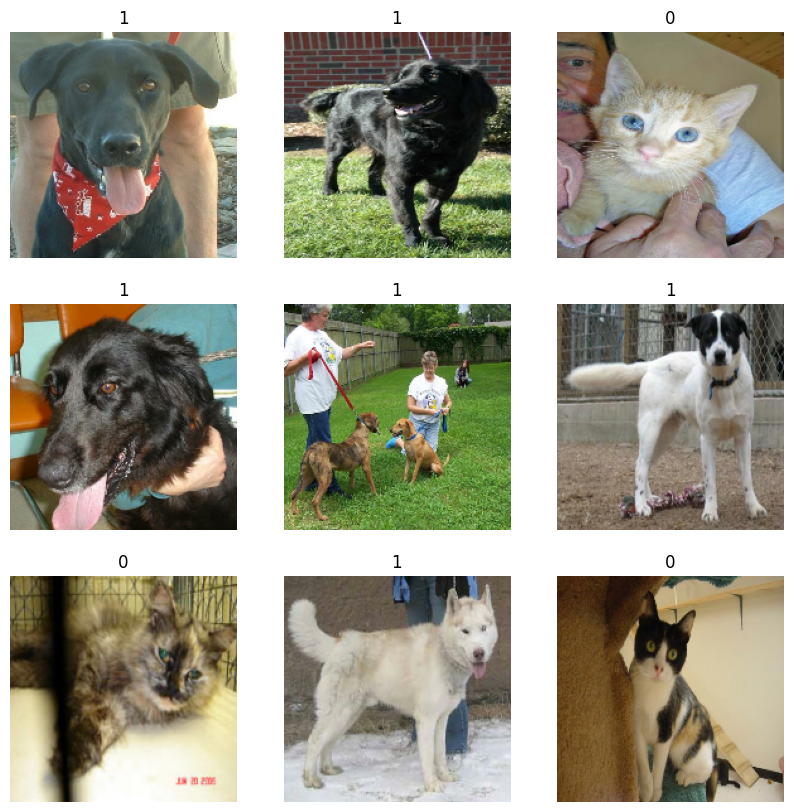

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

<h4>Data augmentation</h4>
Data augmentation is a crucial technique that involves artificially expanding the size and diversity of a training dataset by creating modified versions of existing data. This method is particularly beneficial in scenarios where obtaining large datasets is challenging or expensive.example of transformations include random horizontal flipping or small random rotations.Data augmentation helps mitigate overfitting

In [13]:
from tensorflow.keras import layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]
def data_augmentation(images, training=True):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

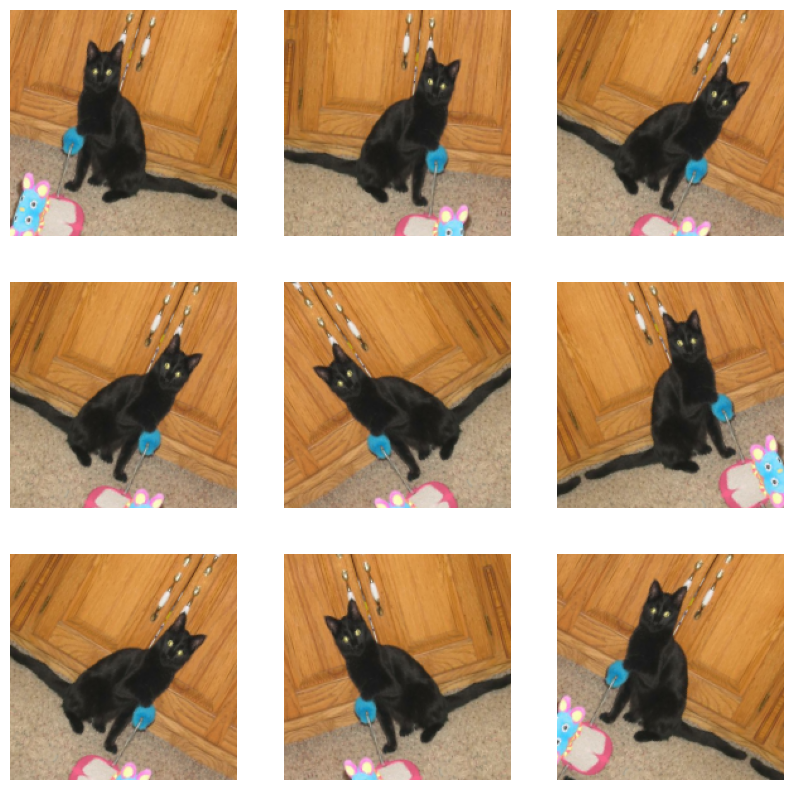

In [14]:
# visualize the augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

<h4>Standardizing the data</h4>
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.



In [15]:
# obtain a dataset that yields batches of augmented images
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

<h4>Configure the dataset for performance</h4>
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [16]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

<h4>Build the Model</h4>


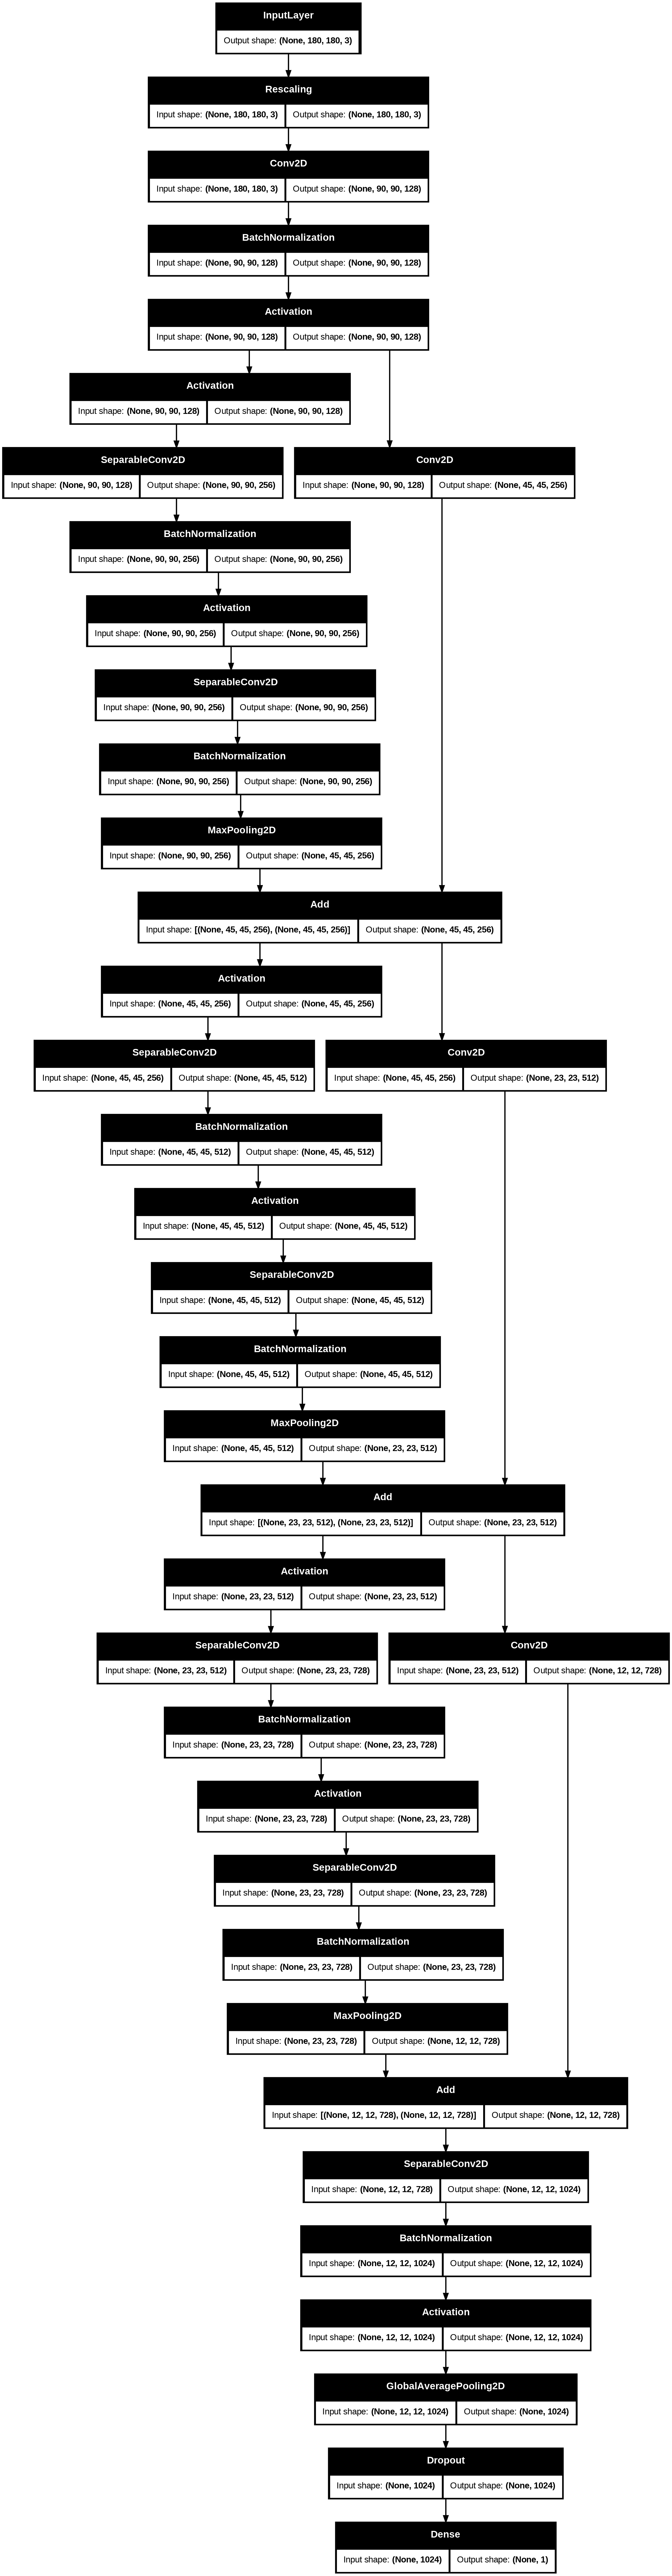

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [20]:
#Train the Model
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define number of epochs
epochs = 25

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor='val_acc',  # Monitor validation accuracy
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Stop training when validation loss stops improving
        patience=5,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True  # Restore weights from the best epoch
    ),
    keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)  # Enable TensorBoard logging
]

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Fit the model with validation data and callbacks
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=1  # Set verbose to get detailed output during training
)


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.6286 - loss: 0.6328
Epoch 1: val_acc improved from -inf to 0.49573, saving model to best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - acc: 0.6289 - loss: 0.6324 - val_acc: 0.4957 - val_loss: 0.6964
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7535 - loss: 0.4901
Epoch 2: val_acc did not improve from 0.49573
147/147 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - acc: 0.7536 - loss: 0.4899 - val_acc: 0.4957 - val_loss: 0.6925
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8111 - loss: 0.3953
Epoch 3: val_acc improved from 0.49573 to 0.49680, saving model to best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.8112 - loss: 0.3952 - val_acc: 0.4968 - val_loss: 0.6989
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8523 - loss: 0.3310
Epoch 4: val_acc did not improve from 0.49680
147/147 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - acc: 0.8523 - loss: 0.3309 - val_acc: 0.4955 - val_loss

We get to >90% validation accuracy after training for 16 epochs(early stopping to avoid perfomance degradation)



<h4>Run inference on new data</h4>


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image is 99.62% cat and 0.38% dog.


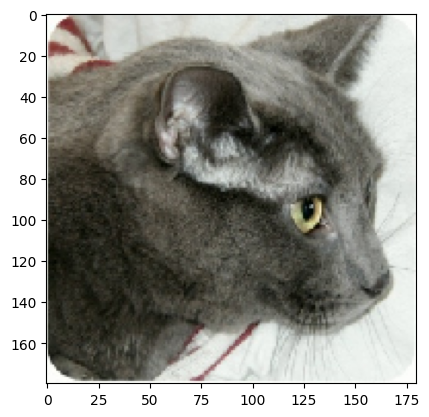

In [22]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")